 # First raw analysis 

In [1]:
%run 20_testing_different_bandwidths.ipynb

data_folder = ../Psychopy_data/pilot/B_theta_sf
Overwriting tmp/exp.py
]0;IPython: Notebooks/W17
 Initializing
B_thetas =  [0.09817477 0.18005332 0.33021925 0.60562477 1.11072073]
B_sfs =  [0.0625 0.125  0.25   0.5    1.    ]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
data_folder

'../Psychopy_data/pilot/B_theta_sf'

In [4]:

subj_name_list =  ['HL','JF25','AB','MP'] #changer et mettre le nom des nouveaux participants
subj_name_list =  ['LP',] #changer et mettre le nom des nouveaux participants

                
subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [5]:

B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)

B_sf_list = []
for x in subj_data_list[0] :
    B_sf_list.append(x[4])
B_sf_list = sorted(set(B_sf_list))
print('B_sf_list=', B_sf_list)


B_theta_list= [5.625, 10.316295486052553, 18.920169343208578, 34.69974357167867, 63.63961030678928]
B_sf_list= [0.0625, 0.125, 0.25, 0.5, 1.0]


### Theta/Btheta

In [6]:
import numpy as np
from matplotlib.pyplot import cm

## B_sf/ B_theta

In [7]:
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(B_theta_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(B_sf_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.05 - 1), 0.0, np.log(10.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(
    theta, ind_condition, y,
    logit0_init=logit0_init * torch.ones(1), theta0_init=theta0_init*torch.ones(N_conditions), 
    log_wt_init=torch.log(log_wt_init*torch.ones(N_conditions)), 
    bias=bias,
    learning_rate=learning_rate,
    # batch_size=batch_size,  # previous notebook showed that learning_rate had no influence on performance
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = LogisticRegressionModel(logit0_init, theta0_init, log_wt_init, bias=bias)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []

    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    return logistic_model, loss

In [9]:
bias = False
#bias = True
for num, data in enumerate(subj_data_list) :
    logistic_model, loss = fit_data(data_dict[num]['theta'], 
                                    data_dict[num]['conditions'], 
                                    data_dict[num]['response'], bias=bias, verbose=True)
    print("Final loss =", loss)

Iteration: 0 - Loss: 248.62241
Iteration: 128 - Loss: 204.74866
Iteration: 256 - Loss: 182.28192
Iteration: 384 - Loss: 174.93431
Iteration: 512 - Loss: 172.30743
Iteration: 640 - Loss: 171.09500
Iteration: 768 - Loss: 170.40505
Iteration: 896 - Loss: 169.97666
Iteration: 1024 - Loss: 169.71982
Iteration: 1152 - Loss: 169.56036
Iteration: 1280 - Loss: 169.45225
Iteration: 1408 - Loss: 169.37370
Iteration: 1536 - Loss: 169.31386
Iteration: 1664 - Loss: 169.26669
Iteration: 1792 - Loss: 169.22852
Iteration: 1920 - Loss: 169.19699
Iteration: 2048 - Loss: 169.17051
Iteration: 2176 - Loss: 169.14796
Iteration: 2304 - Loss: 169.12852
Iteration: 2432 - Loss: 169.11160
Iteration: 2560 - Loss: 169.09674
Iteration: 2688 - Loss: 169.08359
Iteration: 2816 - Loss: 169.07187
Iteration: 2944 - Loss: 169.06137
Iteration: 3072 - Loss: 169.05191
Iteration: 3200 - Loss: 169.04334
Iteration: 3328 - Loss: 169.03556
Iteration: 3456 - Loss: 169.02846
Iteration: 3584 - Loss: 169.02197
Iteration: 3712 - Loss: 

In [10]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_


theta0_, wt_, p0_ = get_params(logistic_model, verbose=True)

slope = 0.320, 3.311, 0.654, 9.396, 7.772, 0.027, 0.183, 5.855, 55.164, 28.031, 0.095, 5.004, 5.818, 3.881, 348.531, 0.693, 1.076, 1.744, 8.941, 10.109, 2.435, 0.443, 0.237, 0.604, 0.615
p0 = 0.080


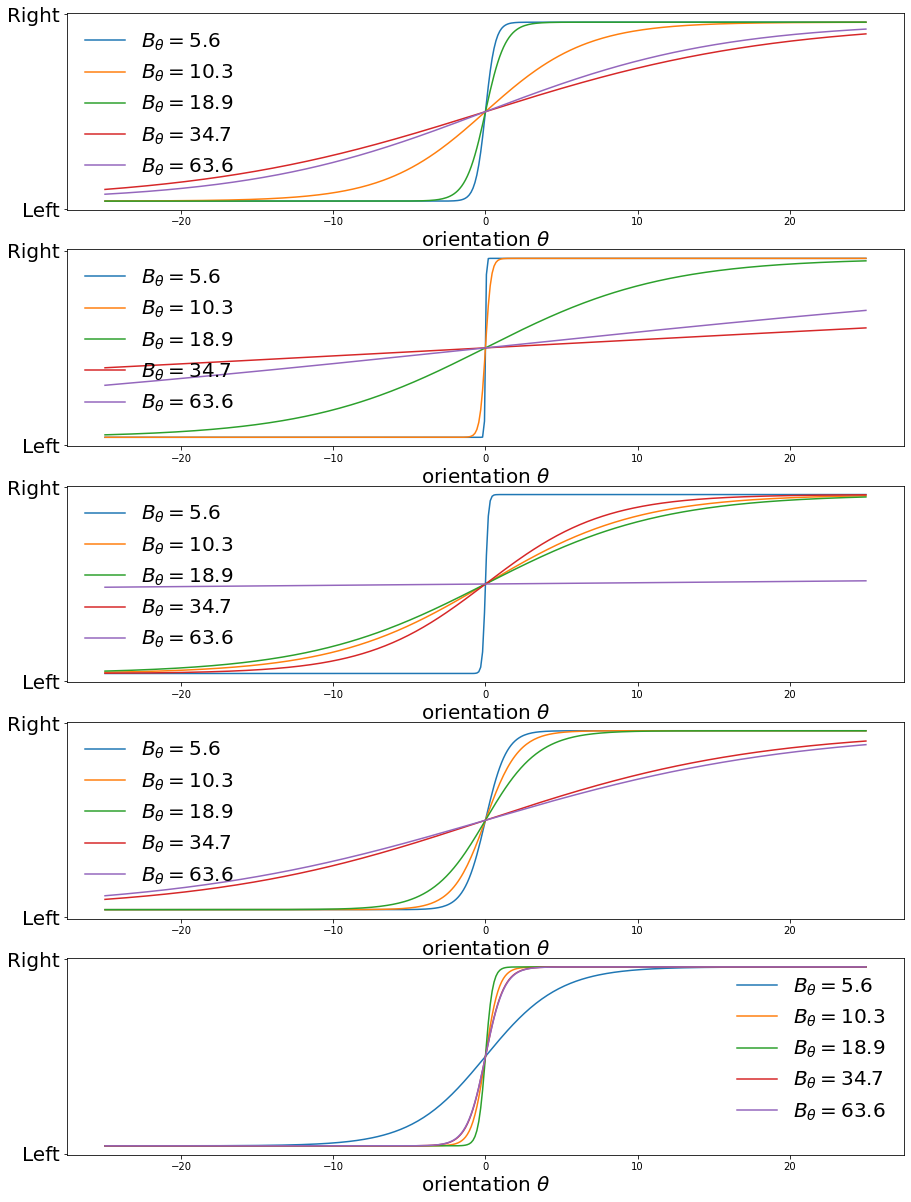

In [11]:
#for num, data in enumerate(subj_data_list) :

fig, axs = plt.subplots(len(B_sf_list), 1, figsize=(15, 21))
x_values = np.linspace(-25, 25, 400)

for i_B_sf, B_sf in enumerate(B_sf_list):
    ax = axs[i_B_sf]
    
    #colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

    for i_B_theta, B_theta in enumerate(B_theta_list):
        i_condition = i_B_theta + i_B_sf*len(B_theta_list)
        conditions = i_condition*np.ones_like(x_values)
        y_values = logistic_model(torch.Tensor(x_values), 
                                  torch.ByteTensor(conditions)).detach().numpy()
        ax.plot(x_values, y_values, label=r'$B_\theta=%s$' % f'{B_theta:.1f}')
            
    ax.set_xlabel(r"orientation $\theta$", fontsize=20)
    ax.set_yticks([0.0, 1.0])
    ax.set_yticklabels(["Left", "Right"], fontsize=20)
    ax.legend(fontsize=20, frameon=False, scatterpoints=6)
    #if i_B_sf==0: ax.legend(fontsize=20, frameon=False, scatterpoints=6)


In [12]:
wt_

array([3.20217844e-01, 3.31111015e+00, 6.53909156e-01, 9.39594233e+00,
       7.77152437e+00, 2.71554839e-02, 1.82727141e-01, 5.85493856e+00,
       5.51635036e+01, 2.80308476e+01, 9.45589589e-02, 5.00364859e+00,
       5.81775210e+00, 3.88076203e+00, 3.48530952e+02, 6.93123683e-01,
       1.07585478e+00, 1.74443520e+00, 8.94082415e+00, 1.01090783e+01,
       2.43541049e+00, 4.42860150e-01, 2.37358698e-01, 6.03579840e-01,
       6.15324674e-01])

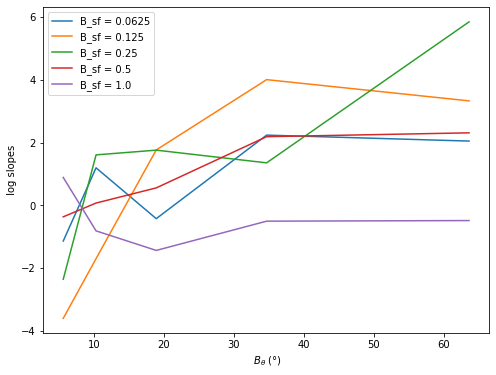

In [13]:
coef_list = []
plt.figure(figsize = (8,6)) 
for i_B_sf, B_sf in enumerate(B_sf_list):
    wt__ = wt_[(i_B_sf*len(B_theta_list)):((i_B_sf+1)*len(B_theta_list))]
    plt.plot(B_theta_list, np.log(wt__), label='B_sf = %s' % B_sf)
plt.xlabel(r' $B_\theta$ (°)')
plt.ylabel(r' log slopes ')
plt.legend(loc ='best') 
plt.show()